<div><img src="images/apple_logo_black.svg", width=100></div>

# Business Problem

Apple has asked me to create a strong predictive model for detecting positive, negative, and neutral sentiment in tweets. They are primarily concerned with tweets about their company and products, but also want to know what people are saying about competitors like Google. My goals are:

1. Create an accurate classifier which can classify **novel tweets** as positive, negative, or neutral.
2. Find out what people are saying about Apple and Google (at South by Southwest, 2011).
3. Make some recommendations based on my findings.

# Imports
Because there are so many of them, I've created a separate section.
## Standard Library and External

In [1]:
import re
import string
from functools import partial
from operator import itemgetter, attrgetter
from os.path import normpath

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.parsing.preprocessing import STOPWORDS
from nltk.collocations import BigramAssocMeasures
from nltk.tokenize.destructive import NLTKWordTokenizer
from nltk.tokenize.treebank import TreebankWordTokenizer
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    HashingVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import (
    Binarizer,
    FunctionTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
)

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## My Package
I put a lot of time and energy into developing my own tools for analysis. It's probably my favorite part of this kind of work, and I (admittedly) tend to get carried away with it. I developed a lot in the `tools.language` module for this project in particular.

#### Caching
Some computationally expensive functions in `tools.language` implement caching, allowing them to save the results of previous calls and reuse them. This **dramatically increases their performance** when being called over and over again as part of a preprocessing pipeline. Essentially, after the function has been called once with certain parameters, every subsequent call with those parameters is fulfilled instantly. This is a highly non-trivial development, which increases the speed of parameter searches (e.g. with `GridSearchCV`) and makes model development more efficient in general.

#### Polymorphism
I've designed the text processing functions in `tools.language` to be polymorphic: capable of handling both a single string document and various types of iterables of documents. This level of flexibility is arguably overkill for the present task, but it allows the functions to be easily deployed within Scikit-Learn's `FunctionTransformer` (where they take array input) or as the `TfidfVectorizer.preprocessor` (where they take string input). They can also directly handle Pandas `Series` objects.

#### VaderVectorizer
Another notable development is the `VaderVectorizer`, which extracts VADER (Valence Aware Dictionary and Sentiment Reasoner) polarity scores from documents and turns them into short vectors of shape (n_samples, 4). This is essentially just a fancy wrapper around the VADER tools from NLTK, which integrates them with the Scikit-Learn API. Nevertheless, it proved very useful for the current project.

In [2]:
# Import my modules
from tools import cleaning, plotting, language as lang, utils
from tools.modeling.vectorizers import VaderVectorizer
from tools.modeling.classification import diagnostics as diag
from tools.modeling.selection import sweep, load_results

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# RandomState for reproducibility
rando = np.random.RandomState(9547)

<IPython.core.display.Javascript object>

# Overview of Dataset
Since Apple is interested in sentiment analysis on Twitter, I've found a Twitter dataset with crowdsourced sentiment labels. It comes from [CrowdFlower](https://data.world/crowdflower), which has released other similar datasets.

The tweets are related to South by Southwest, an annual arts festival in Austin, Texas. They are from 2011, when Apple launched the iPad 2.

It has only three features: the tweet text, the brand object of the sentiment, and the sentiment. It has only about 9,100 tweets.

In [3]:
df = pd.read_csv(normpath("data/crowdflower_tweets.csv"))
df.head()

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

<IPython.core.display.Javascript object>

The dataset contains one text feature and two categorical features, one of which has a lot of null values. The feature names are very long and wordy, presumably to reflect the actual language used by CrowdFlower in crowdsourcing the dataset. I'm going to rename those before I do anything else.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<IPython.core.display.Javascript object>

# Cleaning
## Renaming

In [5]:
# Assign new column names
df.columns = ["text", "object_of_emotion", "emotion"]
df.head()

text   object_of_emotion  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

            emotion  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion

<IPython.core.display.Javascript object>

Next, I take a look at the values of the categorical variables. The categories make sense, although the names are longer than necessary. I'm going to shorten some of them as well.

In [6]:
cleaning.show_uniques(df)

<IPython.core.display.Javascript object>

First, I convert the categorical columns to `CategoricalDtype`. This will make it easier to rename the categories, and is a convenient way to differentiate the categorical features from the text column.

In [7]:
# Convert categorical columns to categorical dtype
cat_cols = ["emotion", "object_of_emotion"]
df[cat_cols] = df.loc[:, cat_cols].astype("category")

# Delete temp variable
del cat_cols

# Display results
display(df["emotion"].head(3), df["object_of_emotion"].head(3))

0    Negative emotion
1    Positive emotion
2    Positive emotion
Name: emotion, dtype: category
Categories (4, object): ['I can't tell', 'Negative emotion', 'No emotion toward brand or product', 'Positive emotion']

0                iPhone
1    iPad or iPhone App
2                  iPad
Name: object_of_emotion, dtype: category
Categories (9, object): ['Android', 'Android App', 'Apple', 'Google', ..., 'Other Google product or service', 'iPad', 'iPad or iPhone App', 'iPhone']

<IPython.core.display.Javascript object>

Next, I rename the categories for both categorical features.

I use a single `dict` mapping old category names to new ones. I only need one `dict` for both features because the method `Series.cat.rename_categories(...)` ignores irrelevant keys.

In [8]:
# Create mapping of old categories to new ones
new_cats = {
    # New 'emotion' categories
    "Negative emotion": "Negative",
    "Positive emotion": "Positive",
    "No emotion toward brand or product": "Neutral",
    "I can't tell": "Uncertain",
    # New 'object_of_emotion' categories
    "iPad or iPhone App": "iOS App",
    "Other Google product or service": "Other Google Product",
    "Other Apple product or service": "Other Apple Product",
}

# Rename categories in-place (ignores irrelevant keys)
df["emotion"].cat.rename_categories(new_cats, inplace=True)
df["object_of_emotion"].cat.rename_categories(new_cats, inplace=True)

# Delete renaming dict
del new_cats

# Show results
cleaning.show_uniques(df)

<IPython.core.display.Javascript object>

The 'Neutral' category dominates the distribution, and 'Negative' is very underrepresented. 'Uncertain' is fortunately a very small 2% of the samples. That's good, because it's completely useless to me.

<AxesSubplot:title={'center':"'emotion' Value Counts"}, xlabel='Count'>

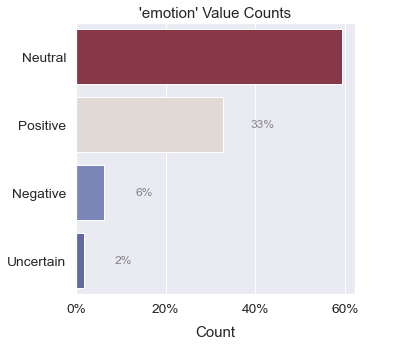

<IPython.core.display.Javascript object>

In [9]:
plotting.countplot(df["emotion"], normalize=True)

I drop the uncertain category, which doesn't have any clear value. I will have to cope with this imbalance later.

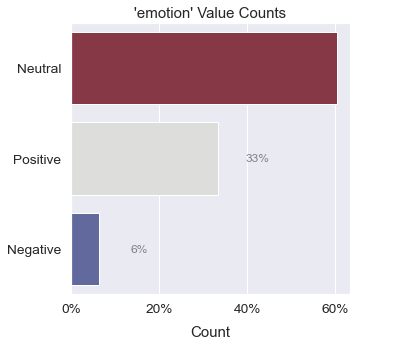

<IPython.core.display.Javascript object>

In [10]:
# Remove 'Uncertain' category
df.emotion.cat.remove_categories("Uncertain", inplace=True)
plotting.countplot(df.emotion, normalize=True)
plt.savefig(normpath("images/class_balance.svg"), bbox_inches="tight")

## Missing Values

According to the table below, there are a lot of missing values in the 'object_of_emotion' category. I bet, however, that these NaN values correspond to the 'Neutral' category. If a tweet doesn't express a brand-emotion, then there shouldn't be any brand in the 'object_of_emotion' column.

There's also one null 'text' row, and a bunch of null 'emotion' rows where the 'Uncertain' category used to be.

In [11]:
cleaning.info(df)

null  null_%  uniq  uniq_%  dup  dup_%
object_of_emotion  5802   63.81     9    0.10   22   0.24
emotion             156    1.72     3    0.03   22   0.24
text                  1    0.01  9065   99.69   22   0.24

<IPython.core.display.Javascript object>

 I'll go ahead and drop the nulls in the 'text' and 'emotion' columns first.

In [12]:
df.dropna(subset=["text", "emotion"], inplace=True)
cleaning.info(df)

null  null_%  uniq  uniq_%  dup  dup_%
object_of_emotion  5654   63.27     9    0.10   22   0.25
text                  0    0.00  8909   99.70   22   0.25
emotion               0    0.00     3    0.03   22   0.25

<IPython.core.display.Javascript object>

In [13]:
null_rows = cleaning.null_rows(df)
lang.readable_sample(null_rows["text"], random_state=rando)

|      | text                                                                                                                                    |
|-----:|:----------------------------------------------------------------------------------------------------------------------------------------|
| 5140 | RT @mention @mention New iPad Apps For Speech Therapy And Communication Are Showcased At #SXSW Conference {link} #sxswi #hcsm #sxswh    |
|  509 | Please RT Follow the next big #college social network @mention chance to win an #iPad at 7,000 followers #socialmedia #SXSW             |
| 4916 | millions of iPhone cases at #SXSW trade show but can any of them double as shuffleboard wax sprinklers? I think not. #fail (CC @mention |
| 6384 | RT @mention not launching any products at #SXSW but we're doing plenty else.  {link}                                                    |
|  790 | Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw&quot;                                             |
| 8793 | Google giving Social another go? {link} Google Circles, let's see what the guys at #SXSW make of it                                     |
| 8452 | @mention The unofficial #SXSW torrents are a great way to hear what you can expect this year {link}                                     |
| 3645 | U gotta fight for yr right to party &amp; to privacy ACLU/google #sxsw #partylikeits1986                                                |
|   61 | #futuremf @mention {link} spec for recipes on the web, now in google search: {link}  #sxsw                                              |
| 4081 | Hope people ask the tough questions. RT @mention Reminder: Android and Chrome TTS talk @mention 1 PM today!  {link}  #sxsw              |

<IPython.core.display.Javascript object>

Looks like some of the NaN values don't line up with the 'Neutral' category. Also, it's important to note that some retweets, e.g. 64, 68, do have sentimental content beyond that of the original tweet.

In [14]:
emotion_without_object = null_rows.loc[null_rows.emotion != "Neutral"]

# Delete variable
del null_rows

display(emotion_without_object.head(), emotion_without_object.shape)

text object_of_emotion  \
46   Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...               NaN   
64   Again? RT @mention Line at the Apple store is ...               NaN   
68   Boooo! RT @mention Flipboard is developing an ...               NaN   
103  Know that &quot;dataviz&quot; translates to &q...               NaN   
112  Spark for #android is up for a #teamandroid aw...               NaN   

      emotion  
46   Positive  
64   Negative  
68   Negative  
103  Negative  
112  Positive

(357, 3)

<IPython.core.display.Javascript object>

These are positive tweets which are missing a brand label. Many of them seem positive, some towards a brand and some not. The original features names were 'emotion_in_tweet_is_directed_at' and 'is_there_an_emotion_directed_at_a_brand_or_product', which is not consistent with brandless positivity. But this is data science, and in data science, nothing is consistent.

In [15]:
lang.readable_sample(
    emotion_without_object.groupby("emotion").get_group("Positive").text,
    random_state=456,
)

|      | text                                                                                                                                           |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------------------------|
| 6606 | RT @mention RT @mention Shiny new @mention @mention @eightbit apps, a new @garyvee book, pop-up iPad 2 stores... #SXSW is Christmas for nerds. |
| 4164 | Mad long line for Google party at Maggie Mae's. Hope it's worth it.. but with 80s theme I am very optimistic #sxsw                             |
| 3020 | Apple offers original iPad donation program {link} #entry #friends #house #sxsw                                                                |
| 8114 | #touchingstories giving us the background to STARTING. Great to hear after yesterday's presos on #uncertainty #iPad and/or #tablet #SXSW       |
|  555 | I have my golden tickets f 4sq party Day after the real party #Redbullbpm with Felix da Housecat playing on iPad! #SXSW  {link}                |
| 5501 | RT @mention At #sxsw even the cabbies are tech savvy. That's his iPhone streaming twitter. @mention  {link}                                    |
| 6676 | RT @mention Soundtrckr featured by @mention @mention as a Must-have for #SXSW {link}                                                           |
|  157 | @mention  #SXSW LonelyPlanet Austin guide for #iPhone is free for a limited time {link} #lp #travel                                            |
| 5019 | Here he comes ladies! @mention  @mention  RT @mention I'll be at Austin Convention Center w/  @mention showing my  iPhone game. #SXSW          |
| 8025 | Someone asks Leo about an iPad 2 at #SXSW, he says 'Email me, I'll send you one free'. O.o                                                     |

<IPython.core.display.Javascript object>

Fortunately there aren't very many of them, so not much hangs on my decision to go ahead and fill in the missing brands.

In [16]:
# Create regex for finding each brand
re_apple = r"ipad\d?\s*app|ipad\d?|iphone\s*app|iphone|apple"
re_google = r"android\s*app|android|google"

# Find all brand/product name occurrences for each brand
findings = lang.locate_patterns(
    re_apple,
    re_google,
    strings=emotion_without_object["text"],
    exclusive=True,
    flags=re.I,
)

# Convert to lowercase
findings = findings.str.lower()

# View results
display(
    findings.value_counts(),
    findings.size,
)

google         122
ipad            98
apple           76
iphone          57
ipad2           26
android         19
iphone app       8
ipad app         4
android app      1
ipad1            1
Name: locate_patterns, dtype: int64

412

<IPython.core.display.Javascript object>

In [17]:
# Rename Apple apps to match categories defined previously
findings = findings.str.replace(
    r"ipad\s+app|iphone\s+app", "ios app", case=False, regex=True
)

# Fuzzy match with previously defined categories
findings = lang.fuzzy_match(findings, df["object_of_emotion"].cat.categories)

# View results
findings.sort_values("score")

original   match  score
5401    ipad2    iPad     89
3179    ipad2    iPad     89
8149    ipad2    iPad     89
6309    ipad2    iPad     89
3710    ipad2    iPad     89
...       ...     ...    ...
3224     ipad    iPad    100
3179     ipad    iPad    100
3134   google  Google    100
3055     ipad    iPad    100
9054     ipad    iPad    100

[412 rows x 3 columns]

<IPython.core.display.Javascript object>

In [18]:
# Define sort order, i.e. fill priority
order = [
    "iOS App",
    "Android App",
    "iPhone",
    "iPad",
    "Android",
    "Apple",
    "Google",
]

# Sort values in reverse order
utils.explicit_sort(
    findings,
    order=order,
    by="match",
    ascending=False,
    inplace=True,
)

# Fill in reverse, overwriting lower priority values
for i, brand in findings.match.items():
    df.at[i, "object_of_emotion"] = brand
df.loc[findings.index].sample(10, random_state=rando)

text object_of_emotion  \
8029  Yeah I wasn't doing it, but I got couldn't res...              iPad   
2753  I love the waves!!!!!! {link} iPad Webber #jap...              iPad   
8973  Google guy at #sxsw talk is explaining how he ...            Google   
1089  ���@mention So @mention just spilled the beans...            iPhone   
4674  Apple opening up temporary store in downtown A...              iPad   
4536  Whoa - line for ipad2 is 3blks long!!! #apple ...              iPad   
6078  RT @mention I'm debuting my new iPhone &amp; D...            iPhone   
6710  RT @mention Temporary #apple store is def not ...             Apple   
682   #technews iPad 2 Gets Temporary Apple Store fo...              iPad   
5501  RT @mention At #sxsw even the cabbies are tech...            iPhone   

       emotion  
8029  Positive  
2753  Positive  
8973  Negative  
1089  Positive  
4674  Positive  
4536  Positive  
6078  Positive  
6710  Positive  
682   Positive  
5501  Positive

<IPython.core.display.Javascript object>

In [19]:
# Get indices which were not filled
emotion_without_object.drop(findings.index, inplace=True)

# Drop unfilled observations
df.drop(emotion_without_object.index, inplace=True)

print(f"{emotion_without_object.shape[0]} observations dropped.")

del emotion_without_object

24 observations dropped.


<IPython.core.display.Javascript object>

Here are the tweets which are labeled 'Neutral' but have a brand label, implying that a non-neutral emotion is being expressed towards a brand. Most 'Neutral' tweets do not have a brand label, so these 91 tweets are an anomaly.

In [20]:
object_without_emotion = df.loc[
    (df.emotion == "Neutral") & df.object_of_emotion.notnull()
]
display(object_without_emotion.head(), object_without_emotion.shape)

text     object_of_emotion  \
63   #Smile RT @mention I think Apple's &quot;pop-u...                 Apple   
265  The #SXSW Apple &quot;pop-up&quot; store was n...                 Apple   
317  I arrived at #sxsw and my @mention issue hasn'...               iOS App   
558  haha. the google &quot;Party like it's 1986&qu...                Google   
588  Diller on Google TV: &quot;The first product w...  Other Google Product   

     emotion  
63   Neutral  
265  Neutral  
317  Neutral  
558  Neutral  
588  Neutral

(91, 3)

<IPython.core.display.Javascript object>

Tweet 6517 seems clearly negative to me, and 7137 seems kind of sardonic. 2666 seems weakly positive. 8647, 5696, 7521, 668, and 265 don't seem to express an emotion toward a brand or product. Since most of them seem neutral to me, and that's consistent with their 'Neutral' label, I'm going to keep them that way.

In [21]:
lang.readable_sample(object_without_emotion["text"], random_state=rando)

|      | text                                                                                                                                              |
|-----:|:--------------------------------------------------------------------------------------------------------------------------------------------------|
|  668 | #sxsw guy in front of me at this panel has an ipad in an etch-a-sketch case...device of wondeR? #iusxsw                                           |
| 1628 | @mention @mention Similarily, Tweetcaster for Android lets you zip tweets w annoying hash tags, like #sxsw                                        |
| 1253 | Google vp to speak. The topic: 10 quick steps to owning everything in the world. #sxsw {link}                                                     |
| 2849 | Nice to see the speaker sneak in an irrelevant snarky comment about Apple. Class!  #sxsw #authenticationdesign                                    |
| 7658 | Score a free imo tshirt outside the SXSW Apple store today at 2:15 PM &amp; check out imo's app for the iPad 2  {link}  #sxsw #ipad2              |
| 4119 | From #Apple to Naomi Campbell: pop-up stores are all the rage: {link} #sxsw                                                                       |
| 5912 | RT @mention Google to launch new social network at SXSW? - CNET News {link} #sxsw                                                                 |
| 6082 | RT @mention I'm not really at #sxsw. Just messing with you. I'm making money instead. // I bet someone left the iPad queue                        |
| 6491 | RT @mention RT @mention &quot;IAVA wants to be the Google of nonprofits.&quot; / yes, we do b/c our #vets deserve nothing less! #sxsw #letshookup |
| 8902 | @mention Which is to say iPad is going to be ubiquitous a lot faster than anyone expected a year or even 6 mo. ago. #newsapps #sxsw               |

<IPython.core.display.Javascript object>

In [22]:
# Set object to null where emotion is neutral
df.loc[object_without_emotion.index, "object_of_emotion"] = np.nan

# Ensure that 'Neutral' rows line up with 'NaN' rows
(df["emotion"] == "Neutral").equals(df["object_of_emotion"].isnull())

True

<IPython.core.display.Javascript object>

Here's a look at the final distributions.

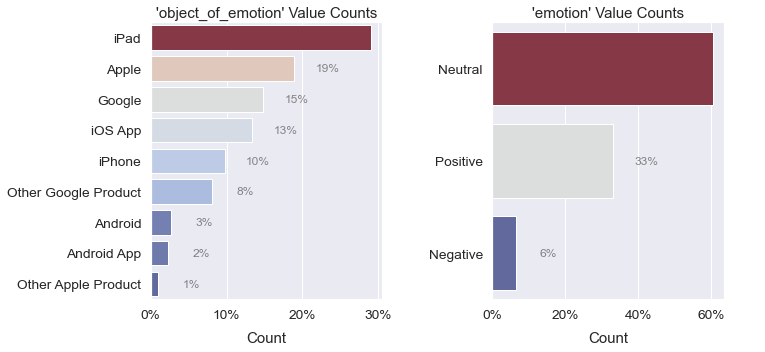

<IPython.core.display.Javascript object>

In [23]:
fig = plotting.countplot(df.select_dtypes("category"), normalize=1)

## Duplicates
There are $22$ duplicate rows, and even more when only the text is considered. I don't want to get rid of all retweets, but I do want to get rid of those which don't have novel content.

In [24]:
cleaning.dup_rows(df.text).sort_values()

3962    #SXSW is just starting, #CTIA is around the co...
468        Before It Even Begins, Apple Wins #SXSW {link}
2559    Counting down the days to #sxsw plus strong Ca...
776     Google to Launch Major New Social Network Call...
8483    I just noticed DST is coming this weekend. How...
2232    Marissa Mayer: Google Will Connect the Digital...
8747    Need to buy an iPad2 while I'm in Austin at #s...
4897    Oh. My. God. The #SXSW app for iPad is pure, u...
5882    RT @mention Google to Launch Major New Social ...
5884    RT @mention Google to Launch Major New Social ...
5883    RT @mention Google to Launch Major New Social ...
5881    RT @mention Google to Launch Major New Social ...
5885    RT @mention Google to Launch Major New Social ...
6299    RT @mention Marissa Mayer: Google Will Connect...
6297    RT @mention Marissa Mayer: Google Will Connect...
6295    RT @mention Marissa Mayer: Google Will Connect...
6300    RT @mention Marissa Mayer: Google Will Connect...
6298    RT @me

<IPython.core.display.Javascript object>

I filter the text by removing occurrences of 'RT' and then check for duplicates. This should get rid of retweets which are just copies of original tweets in the dataset.

In [25]:
dups = df.text.str.replace(r"\s*RT\s*", "", regex=True).duplicated()
df = df.loc[~dups]
dups.sum()

33

<IPython.core.display.Javascript object>

# Feature Engineering
I get organized with text-processing functions and stopword sets, and then engineer some features.

#### Stopword Sets

In [26]:
my_stop = {
    "sxsw",
    "quot",
    "link",
    "austin",
    "mention",
    "sxswi",
    "america",
    "southbysouthwest",
}
brand_stop = {
    "apple",
    "applesxsw",
    "google",
    "android",
    "andoid",
    "app",
    "ipad",
    "iphone",
    "androidsxsw",
}
gensim_stop = set(STOPWORDS)
nltk_stop = set(nltk.corpus.stopwords.words("english"))
pd.Series(list(gensim_stop))

0            his
1           back
2              i
3       formerly
4          every
         ...    
332    something
333      serious
334         move
335         give
336         ours
Length: 337, dtype: object

<IPython.core.display.Javascript object>

#### Text-Processing Functions
Most of these functions from my `tools.language` module are simple polymorphic wrappers around functions from `gensim.parsing.preprocessing` or `nltk`.

Probably the most complex is `wordnet_lemmatize`, which must tokenize text, tag parts of speech, translate the tags, lemmatize the tagged tokens, and then finally detokenize.

In [27]:
funcs = [
    lang.lowercase,
    lang.strip_short,
    lang.strip_punct,
    lang.strip_multiwhite,
    lang.strip_numeric,
    lang.strip_non_alphanum,
    lang.split_alphanum,
    lang.uni2ascii,
    lang.stem_text,
    lang.strip_handles,
    lang.limit_repeats,
    lang.wordnet_lemmatize,
    lang.stem_text,
    lang.mark_pos,
    lang.mark_negation,
]

func_names = utils.get_func_name(funcs)
funcs = pd.Series(dict(zip(func_names, funcs)))
funcs

lowercase                    <function lowercase at 0x0000020C3F1938B0>
strip_short                <function strip_short at 0x0000020C3F193940>
strip_punct                <function strip_punct at 0x0000020C3F197280>
strip_multiwhite      <function strip_multiwhite at 0x0000020C3F1939D0>
strip_numeric            <function strip_numeric at 0x0000020C3F193A60>
strip_non_alphanum    <function strip_non_alphanum at 0x0000020C3F19...
split_alphanum          <function split_alphanum at 0x0000020C3F193B80>
uni2ascii                    <function uni2ascii at 0x0000020C3F1971F0>
stem_text                    <function stem_text at 0x0000020C3F193F70>
strip_handles            <function strip_handles at 0x0000020C3F197040>
limit_repeats            <function limit_repeats at 0x0000020C3F193C10>
wordnet_lemmatize     <function wordnet_lemmatize at 0x0000020C3F19A...
mark_pos                      <function mark_pos at 0x0000020C3F19A5E0>
mark_negation            <function mark_negation at 0x0000020C3F

<IPython.core.display.Javascript object>

In [28]:
filts = [
    "lowercase",
    "strip_handles",
    "uni2ascii",
    "wordnet_lemmatize",
    "strip_punct",
    "strip_numeric",
    "strip_short",
    "limit_repeats",
    "strip_multiwhite",
]

filts = lang.make_preprocessor(funcs.loc[filts].to_list())
filts

functools.partial(<function chain_funcs at 0x0000020C3F197CA0>, funcs=[<function lowercase at 0x0000020C3F1938B0>, <function strip_handles at 0x0000020C3F197040>, <function uni2ascii at 0x0000020C3F1971F0>, <function wordnet_lemmatize at 0x0000020C3F19ADC0>, <function strip_punct at 0x0000020C3F197280>, <function strip_numeric at 0x0000020C3F193A60>, <function strip_short at 0x0000020C3F193940>, <function limit_repeats at 0x0000020C3F193C10>, <function strip_multiwhite at 0x0000020C3F1939D0>])

<IPython.core.display.Javascript object>

In [29]:
df["clean_text"] = filts(df["text"])
df["clean_text"] = lang.strip_stopwords(df["clean_text"], my_stop)
df.clean_text.head()

0    have iphone after tweet rise dead need upgrade...
1    know about awesome ipad iphone app that you li...
2    cannot wait for ipad also they should sale the...
3    hope this year festival ben crashy this year i...
4    great stuff fri marissa mayer google tim reill...
Name: clean_text, dtype: object

<IPython.core.display.Javascript object>

## Brand Terms
I extract brand terms based on the crowdsourced labels using regular expressions. I'm comfortable using these for training the model, since they were extracted algorithmically.

In [30]:
re_brand = fr"{re_apple}|{re_google}"
regex_brands = lang.locate_patterns(re_brand, strings=df.clean_text)
regex_brands = utils.implode(regex_brands).reindex_like(df)
df["brand_terms"] = regex_brands
del regex_brands
df["brand_terms"].head()

0              [iphone]
1    [ipad, iphone app]
2                [ipad]
3          [iphone app]
4              [google]
Name: brand_terms, dtype: object

<IPython.core.display.Javascript object>

## Parts of Speech

I use `nltk.casual_tokenize` a.k.a. `nltk.TweetTokenizer` to extract tokens from the raw text for PoS tagging. This tokenizer is able to capture '@mentions' and 'hashtags' without chopping them up.

In [31]:
# Tokenize and tag using TweetTokenizer
df["tagged"] = lang.tokenize_tag(df["text"], tokenizer=nltk.casual_tokenize)

# My `lang.tokenize_tag` function tokenizes and tags POS all at once, which
# is often convenient, since tagging POS requires tokenization.

df["tagged"].head()

0    [(., .), (@wesley83, NN), (I, PRP), (have, VBP...
1    [(@jessedee, NN), (Know, NNP), (about, IN), (@...
2    [(@swonderlin, NNS), (Can, MD), (not, RB), (wa...
3    [(@sxsw, NN), (I, PRP), (hope, VBP), (this, DT...
4    [(@sxtxstate, JJ), (great, JJ), (stuff, NN), (...
Name: tagged, dtype: object

<IPython.core.display.Javascript object>

I extract just the tags in hopes of analyzing them like words. They can be easily vectorized with `CountVectorizer` or `TfidfVectorizer` if converted to `str`.

**Future work:** Create a PoS extractor/vectorizer which is integrated with the Scikit-Learn API and can be tuned alongside other feature-extractors.

In [32]:
# Explode the lists of tagged-tokens, get the tag, and then "implode"
df["pos_tags"] = utils.implode(df["tagged"].explode().map(itemgetter(1), "ignore"))

# My `utils.implode` function retracts a long-form Series into one
# with unique indices and lists as values.

df["pos_tags"].head()

0    [., NN, PRP, VBP, DT, CD, NN, ., IN, CD, NN, N...
1    [NN, NNP, IN, NNP, ., NNP, NN, NNP, NN, NN, WD...
2    [NNS, MD, RB, VB, IN, JJ, CD, RB, ., PRP, MD, ...
3    [NN, PRP, VBP, DT, NN, NN, NN, RB, JJ, IN, DT,...
4    [JJ, JJ, NN, IN, NNP, NN, :, NNP, NNP, (, NNP,...
Name: pos_tags, dtype: object

<IPython.core.display.Javascript object>

## Simple Counts

I engineer character counts (minus spaces), word counts, and average word lengths. Maybe an interesting pattern will show up.

In [33]:
# String length without whitespace
df["n_chars"] = df["text"].str.replace("\s+", "", regex=True).map(len)

# Number of words as parsed by TweetTokenizer
df["n_words"] = df["text"].map(nltk.casual_tokenize).map(len)

# Calculate average word length
df["avg_word_len"] = df["n_chars"] / df["n_words"]

# Show results
df[["n_chars", "n_words", "avg_word_len"]].head()

n_chars  n_words  avg_word_len
0      104       29      3.586207
1      118       26      4.538462
2       65       17      3.823529
3       68       16      4.250000
4      115       27      4.259259

<IPython.core.display.Javascript object>

I engineer exclamation point and question mark counts, which I've discovered have a surprisingly robust connection to sentiment.

In [34]:
df["ep_count"] = df["text"].str.count(r"\!")
df["qm_count"] = df["text"].str.count(r"\?")
df[["ep_count", "qm_count"]].head()

ep_count  qm_count
0         1         0
1         0         1
2         0         0
3         0         0
4         0         0

<IPython.core.display.Javascript object>

# Exploration
## Bird's Eye View
I begin my exploratory analysis by trying to get an overall sense of what people were talking about regarding Apple and Google.

In [35]:
# Clean text containing the word 'apple'
mentions_apple = df.clean_text.loc[df.clean_text.str.contains("apple")]

# Clean text containing the word 'google'
mentions_google = df.clean_text.loc[df.clean_text.str.contains("google")]

mentions_apple.head()

9     count down the day plus strong canadian dollar...
20        need buy ipad while not sure need apple store
31    you must have this app for your ipad you http ...
36    the best first line for ipad pop apple store e...
39    vatornews google and apple force print medium ...
Name: clean_text, dtype: object

<IPython.core.display.Javascript object>

### Apple's Pop-up Store
Virtually all of the most robust quadgrams (according to the 'likelihood_ratio' metric) are about Apple's pop-up store where the iPad 2 is being launched. [This article](https://money.cnn.com/2011/03/11/technology/ipad_2_launch/index.htm) describes the crowd swarming for the launch.

In [36]:
apple_quad = lang.scored_quadgrams(
    mentions_apple,
    measure="likelihood_ratio",
    tokenizer=nltk.word_tokenize,
    stopwords=my_stop,
    min_freq=5,
)

apple_quad.head(20)

quadgram
apple open pop store             7641.421876
open pop store downtown          7483.101572
apple open temporary store       6864.424187
open temporary store downtown    6730.842501
open pop store for               6122.280478
set open pop store               6073.689262
apple open popup store           5581.155061
pop store downtown for           5497.547978
open temporary store for         5378.897553
open pop store that              5362.006360
have open pop store              5350.723440
apple pop store downtown         5134.940741
rumor apple open temporary       5090.936342
temporary store downtown for     5052.873473
apple open temp store            4823.419340
pop apple store downtown         4776.653123
apple open pop shop              4747.837216
open temp store downtown         4650.705065
not rumor apple open             4572.555290
pop store downtown pic           4435.201075
Name: score, dtype: float64

<IPython.core.display.Javascript object>

### Google Circles
The top quadrams about Google all have to do with the anticipated Google Circles launch.

In [37]:
google_quad = lang.scored_quadgrams(
    mentions_google,
    measure="likelihood_ratio",
    tokenizer=nltk.word_tokenize,
    stopwords=my_stop,
    min_freq=5,
)
google_quad.head(20)

quadgram
new social network call           19626.167802
major new social network          19142.906474
social network call circle        17447.770011
launch major new social           15962.116728
launch new social network         14236.214125
network call circle possibly      14203.573082
google new social network         14039.075642
new social network circle         14020.097781
secret new social network         13997.628443
reveal new social network         13964.745254
new social network today          13933.236316
social network call circles       13115.074996
call circle possibly today        13071.111388
social network google circle      12444.570753
google launch major new           12097.324938
major new social service          11307.857108
preview major new social          11303.169249
social network circle possibly    11090.956064
launch secret new social          10243.507399
network call circle today         10136.787451
Name: score, dtype: float64

<IPython.core.display.Javascript object>

In [38]:
# Clear namespace
del apple_quad, google_quad, mentions_apple, mentions_google

<IPython.core.display.Javascript object>

There is no glaringly obvious pattern in the counts of 'Negative' and 'Positive' tweets for each brand. Talk about the new iPad leads in both the 'Negative' and 'Positive' categories, whereas Google leads in the 'Neutral' category.

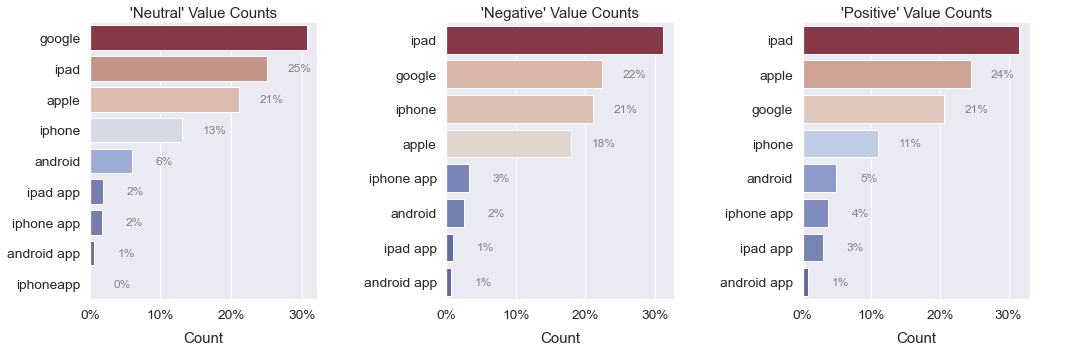

<IPython.core.display.Javascript object>

In [39]:
fig = plotting.countplot(
    df.explode("brand_terms").groupby("emotion")["brand_terms"],
    normalize=True,
)

A color palette for the sentiment classes.

In [40]:
emo_pal = dict(Negative="r", Neutral="gray", Positive="g")
emo_pal

{'Negative': 'r', 'Neutral': 'gray', 'Positive': 'g'}

<IPython.core.display.Javascript object>

It's fascinating how robust of a connection there is between exclamation points and positive sentiment. This is interesting to note for future sentiment analysis work.

Question marks are also pretty robustly non-positive. That makes sense intuitively.

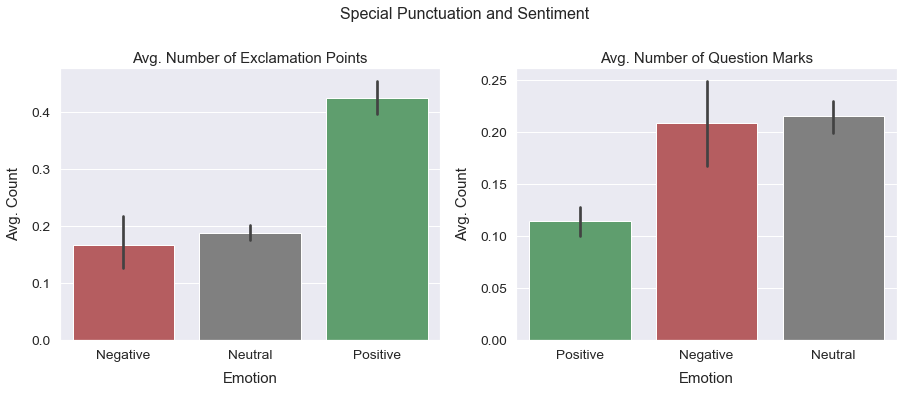

<IPython.core.display.Javascript object>

In [41]:
# Create plot objects
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

# Plot exclamation points on `ax1`
plotting.barplot(
    data=df,
    x="emotion",
    y="ep_count",
    palette=emo_pal,
    ax=ax1,
)

# Plot question marks on `ax2`
plotting.barplot(
    data=df,
    x="emotion",
    y="qm_count",
    palette=emo_pal,
    ax=ax2,
)

# Set `ax1` title and labels
ax1.set(
    title="Avg. Number of Exclamation Points",
    xlabel="Emotion",
    ylabel="Avg. Count",
)

# Set `ax2` title and labels
ax2.set(
    title="Avg. Number of Question Marks",
    xlabel="Emotion",
    ylabel="Avg. Count",
)

fig.suptitle("Special Punctuation and Sentiment", fontsize=16, y=1.05)

fig.savefig(normpath("images/punct_sentiment.svg"), bbox_inches="tight")

## Keywords by Brand

I construct "superdocuments" by grouping by 'emotion' and 'object_of_emotion' and concatenating the raw tweets in each group. Every brand/product will have 2 superdocuments: positive and negative.

In [42]:
brand_docs = (
    # Get Series where each value is a list of row indices
    pd.Series(df.groupby(["emotion", "object_of_emotion"]).groups)
    # Replace lists of row indices with sliced out tweets
    .map(lambda x: df.loc[x, "text"])
    # Fuse the tweets together
    .map(lambda x: " ".join(x))
)
# Get rid of Neutral group and swap index levels
brand_docs = brand_docs.drop(index=np.nan, level=1).swaplevel(0, 1)
brand_docs

Android               Negative    they took away the lego pit but replaced it wi...
Android App           Negative    Beware, the android #sxsw app for schedules is...
Apple                 Negative    Again? RT @mention Line at the Apple store is ...
Google                Negative    @mention  - False Alarm: Google Circles Not Co...
Other Apple Product   Negative    @mention I meant iTunes doesn't work for me (I...
Other Google Product  Negative    ���@mention Google to Launch Major New Social ...
iOS App               Negative    @sxsw I hope this year's festival isn't as cra...
iPad                  Negative    attending @mention iPad design headaches #sxsw...
iPhone                Negative    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
Android               Positive    #SXSW is just starting, #CTIA is around the co...
Android App           Positive    Find &amp; Start Impromptu Parties at #SXSW Wi...
Apple                 Positive    Counting down the days to #sxsw plus stron

<IPython.core.display.Javascript object>

Now I use a `TfidfVectorizer` to extract tf-idf vectors for each superdocument. Each document is transformed into a vector of TF-IDF scores where the features are words. For each term in each superdocument, the score is (roughly) the term's local frequency times a measure of its rarity in the corpus as a whole. I set the 'max_df' to a low 0.15, meaning that terms which occur in more than 15% of the documents are excluded. This separates the wheat from the chaff.

In [43]:
# Make vectorizer
tfidf = TfidfVectorizer(
    tokenizer=nltk.word_tokenize,
    stop_words=filts(my_stop | brand_stop | gensim_stop),
    preprocessor=filts,
    ngram_range=(1, 4),
    max_df=0.15,
    norm="l2",
)
# Make vectors
brand_vecs = tfidf.fit_transform(brand_docs.values)

# Place vectors in DataFrame
brand_vecs = lang.frame_doc_vecs(
    brand_vecs,
    tfidf.vocabulary_,
    brand_docs.index,
)

# Transpose so that vectors run along columns
brand_vecs = brand_vecs.T.sort_index(level=0, axis=1)

# Sort for effect
brand_vecs.sort_values(("Apple", "Negative"), ascending=False)

Android          Android App              Apple  \
                         Negative Positive    Negative Positive  Negative   
fascist                       0.0      0.0         0.0      0.0  0.250808   
fascist company               0.0      0.0         0.0      0.0  0.214978   
classy fascist company        0.0      0.0         0.0      0.0  0.143319   
classy fascist                0.0      0.0         0.0      0.0  0.143319   
classy                        0.0      0.0         0.0      0.0  0.141126   
...                           ...      ...         ...      ...       ...   
goona                         0.0      0.0         0.0      0.0  0.000000   
goona network                 0.0      0.0         0.0      0.0  0.000000   
goona network great           0.0      0.0         0.0      0.0  0.000000   
goona network great idea      0.0      0.0         0.0      0.0  0.000000   
zzzs battery life popup       0.0      0.0         0.0      0.0  0.000000   

                                    Google           Other Apple Product  \
                         Positive Negative  Positive            Negative   
fascist                       0.0      0.0  0.000000                 0.0   
fascist company               0.0      0.0  0.000000                 0.0   
classy fascist company        0.0      0.0  0.000000                 0.0   
classy fascist                0.0      0.0  0.000000                 0.0   
classy                        0.0      0.0  0.012687                 0.0   
...                           ...      ...       ...                 ...   
goona                         0.0      0.0  0.007248                 0.0   
goona network                 0.0      0.0  0.007248                 0.0   
goona network great           0.0      0.0  0.007248                 0.0   
goona network great idea      0.0      0.0  0.007248                 0.0   
zzzs battery life popup       0.0      0.0  0.000000                 0.0   

                                  Other Google Product           iOS App  \
                         Positive             Negative Positive Negative   
fascist                       0.0                  0.0      0.0      0.0   
fascist company               0.0                  0.0      0.0      0.0   
classy fascist company        0.0                  0.0      0.0      0.0   
classy fascist                0.0                  0.0      0.0      0.0   
classy                        0.0                  0.0      0.0      0.0   
...                           ...                  ...      ...      ...   
goona                         0.0                  0.0      0.0      0.0   
goona network                 0.0                  0.0      0.0      0.0   
goona network great           0.0                  0.0      0.0      0.0   
goona network great idea      0.0                  0.0      0.0      0.0   
zzzs battery life popup       0.0                  0.0      0.0      0.0   

                                      iPad             iPhone           
                         Positive Negative Positive  Negative Positive  
fascist                       0.0      0.0      0.0  0.000000      0.0  
fascist company               0.0      0.0      0.0  0.000000      0.0  
classy fascist company        0.0      0.0      0.0  0.000000      0.0  
classy fascist                0.0      0.0      0.0  0.000000      0.0  
classy                        0.0      0.0      0.0  0.000000      0.0  
...                           ...      ...      ...       ...      ...  
goona                         0.0      0.0      0.0  0.000000      0.0  
goona network                 0.0      0.0      0.0  0.000000      0.0  
goona network great           0.0      0.0      0.0  0.000000      0.0  
goona network great idea      0.0      0.0      0.0  0.000000      0.0  
zzzs battery life popup       0.0      0.0      0.0  0.018925      0.0  

[60843 rows x 18 columns]

<IPython.core.display.Javascript object>

In [44]:
def plot_brand_clouds(
    column,
    dst,
    cmap=("Reds", "Greens"),
    size=(10, 4),
    ncols=1,
    max_font_size=110,
    random_state=156,
    brand_vecs=brand_vecs,
    **kwargs,
):
    fig = plotting.wordcloud(
        brand_vecs.loc[:, column],
        cmap=list(cmap),
        size=size,
        ncols=ncols,
        max_font_size=max_font_size,
        random_state=random_state,
        **kwargs,
    )
    fig.savefig(normpath(dst))
    return fig

<IPython.core.display.Javascript object>

### Apple

Here is one of the most striking Wordclouds in the notebook. It reveals that people were talking about Apple being a "fascist company". This began with tech journalist [Kara Swisher](https://en.wikipedia.org/wiki/Kara_Swisher), who provoked a flurry of tweets by saying that Apple was the "classiest fascist company in America".

On the positive side, a lot of people were talking about the pop-up store and circulating the following quote:

> apple comes up with cool technology no one's ever heard of because they don't go to conferences

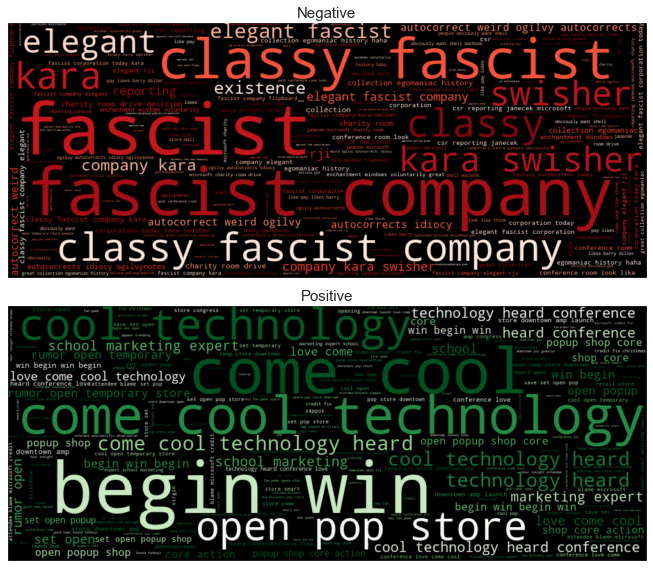

<IPython.core.display.Javascript object>

In [45]:
fig = plot_brand_clouds("Apple", "images/apple_clouds.svg")

### iPhone

Regarding the negative, there was a tweet bragging about T-Mobile, retweeted a few times:

> Looking forward to delicious T-Mobile 4G here in Austin while iPhone users struggle to do anything. #SXSW

There were similar remarks about AT&T's service making iPhone's useless as a brick:
> Austin is getting full, and #SXSW is underway. I can tell because my iPhone is an intermittent brick. #crowded

> Decided to go to LA instead of #SXSW, because my AT&T iPhone would be about as useful as a brick in Austin.

There was also talk about battery life problems, and numerous jokes about autocorrect mishaps.

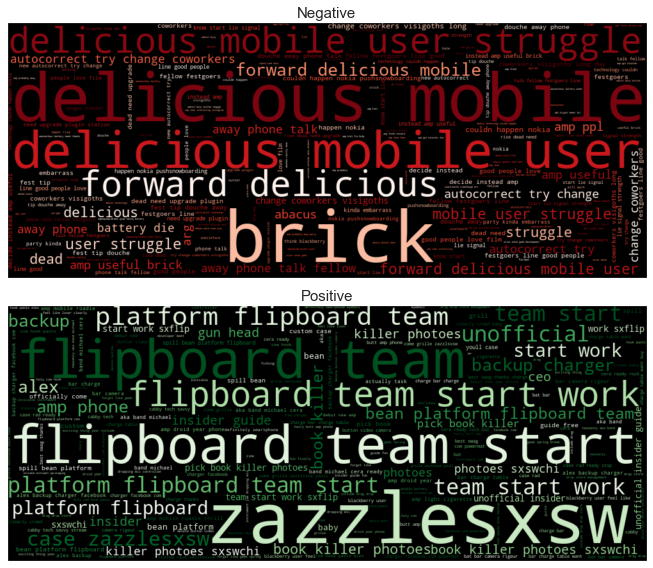

<IPython.core.display.Javascript object>

In [46]:
fig = plot_brand_clouds("iPhone", "images/iphone_clouds.svg")

The positive chatter about [Flipboard](https://flipboard.com/) was related to its well-designed iPad app.

> Epicurious, flipboard, CNN, wired, and MOMA as examples of good iPad design #SXSW {link}

The talk about [Zazzle](https://www.zazzle.com/) was related to designing custom iPhone cases, a service they offer.

> Zazzle is gearing up to hit #SXSW! Look out for our tweets on where you can come by to create your own iPhone case! #zazzlesxsw

### iPad
The talk about "design headaches" is related to a talk given by Josh Clark on the topic of iPad design challenges and failings. It seems like constructive criticism which is not intended to harm the brand.

The talk about "japan relief" has to do with the following virally circulated quote:

> Best thing I've heard this weekend at #SXSW "I gave my iPad 2 money to #Japan relief. I don't need an iPad 2."

The quote expresses a definite negative attitude towards Apple and iPad, which it implies are associated with self-indulgence and excess.

The positive chatter is again focused on the pop-up store, with words like "shiny", "gadget", and "envy" showing up.

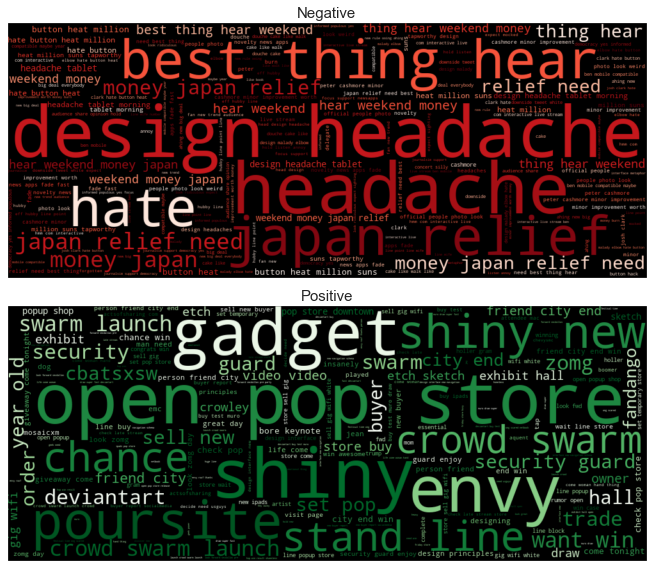

<IPython.core.display.Javascript object>

In [47]:
fig = plot_brand_clouds("iPad", "images/ipad_clouds.svg")

### iOS Apps

The negative chatter seems to focus on the short lifecycle of news apps, and is related to [this article](https://www.theguardian.com/technology/pda/2011/mar/15/sxsw-apple-ipad-news-apps) from the time period.

Holler Gram was a social media app which existed for use at South by Southwest, according [this article](https://www.forbes.com/sites/billbarol/2011/03/07/holler-gram-is-here/?sh=454ea1ed2a60).

These wordclouds don't seem to be as interesting as some of the others.

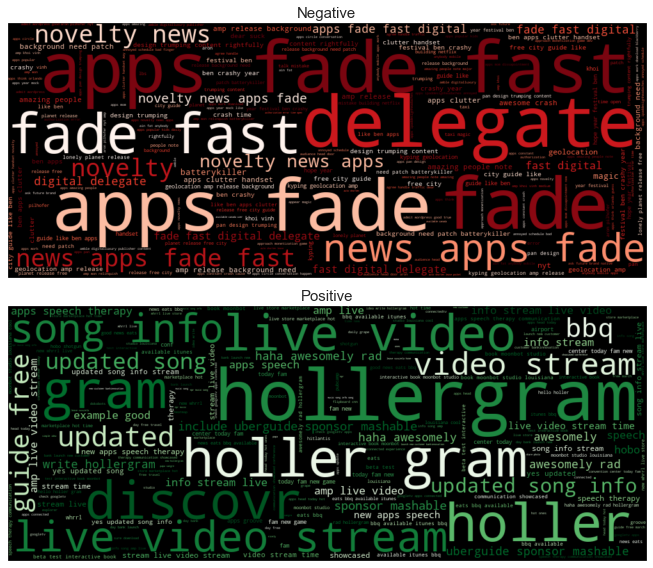

<IPython.core.display.Javascript object>

In [48]:
fig = plot_brand_clouds("iOS App", "images/ios_app_clouds.svg")

In [49]:
lang.readable_sample(df.text.loc[df.text.str.contains("buggy lately")])

|      | text                                                                                             |
|-----:|:-------------------------------------------------------------------------------------------------|
| 8258 | Is it just me or has the @mention client for Android gotten really buggy lately? #SXSW to blame? |

<IPython.core.display.Javascript object>

### Google

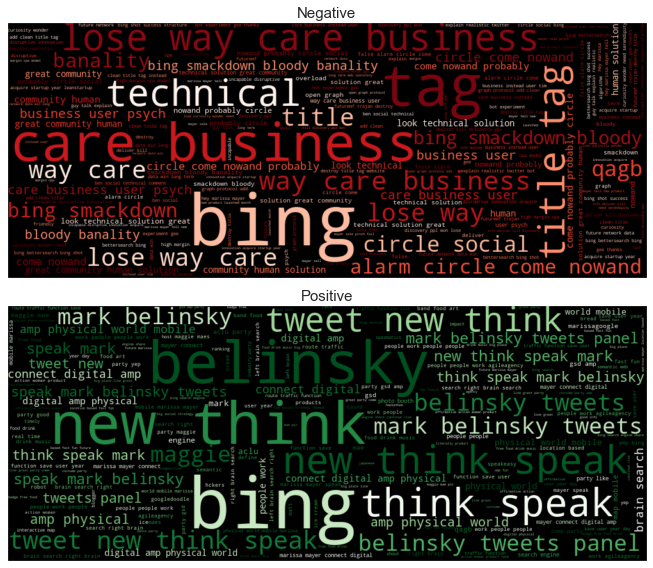

<IPython.core.display.Javascript object>

In [50]:
fig = plot_brand_clouds("Google", "images/google_clouds.svg")

### Android

The most interesting phrase here is "apps like ipod", which appears to originate from the following tweet:

 > @mention Android needs a way to group apps like you can now do with iPad/iPod. #SXSW #hhrs
 
There is also talk about bugginess, as in:

> Is it just me or has the @mention client for Android gotten really buggy lately? #SXSW to blame?

This is good news for Apple.

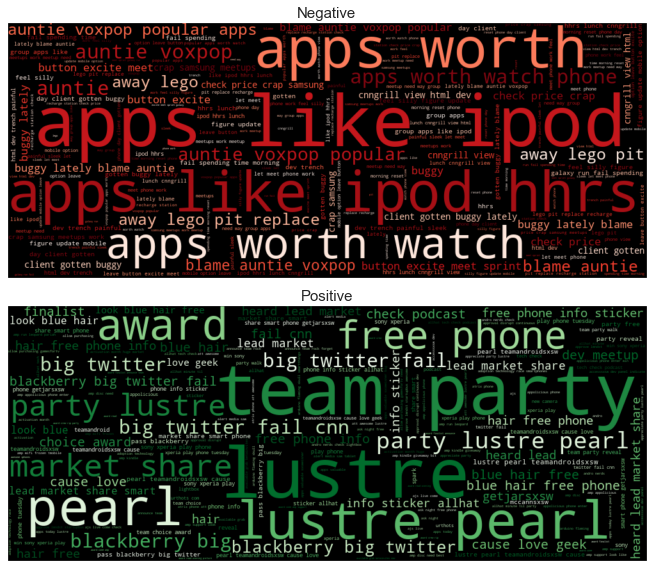

<IPython.core.display.Javascript object>

In [51]:
fig = plot_brand_clouds("Android", "images/android_clouds.svg")

### Android Apps

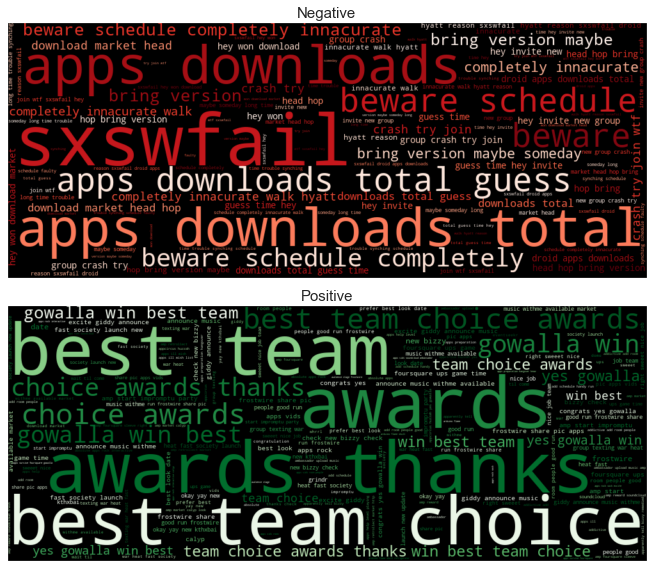

<IPython.core.display.Javascript object>

In [52]:
fig = plot_brand_clouds("Android App", "images/android_clouds.svg")

# Modeling

In [53]:
df["pos_tags"] = df["pos_tags"].str.join(" ")
df["pos_tags"].head()

0    . NN PRP VBP DT CD NN . IN CD NN NN IN NNP , P...
1    NN NNP IN NNP . NNP NN NNP NN NN WDT VBZ JJ NN...
2    NNS MD RB VB IN JJ CD RB . PRP MD NN PRP RP IN...
3     NN PRP VBP DT NN NN NN RB JJ IN DT NN NN NN . NN
4    JJ JJ NN IN NNP NN : NNP NNP ( NNP ) , NNP NNP...
Name: pos_tags, dtype: object

<IPython.core.display.Javascript object>

In [54]:
df["brand_terms"] = utils.implode(
    df["brand_terms"].explode().str.replace(" ", "_").fillna("")
)
df["brand_terms"] = df["brand_terms"].str.join(" ")
df["brand_terms"].head()

0             iphone
1    ipad iphone_app
2               ipad
3         iphone_app
4             google
Name: brand_terms, dtype: object

<IPython.core.display.Javascript object>

## Train-Test-Split

In [55]:
cols = [
    "text",
    "pos_tags",
    "brand_terms",
]
X = df.loc[:, cols].copy()
y = df.emotion.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=rando,
    stratify=y,
    shuffle=True,
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6659, 3), (6659,), (2220, 3), (2220,))

<IPython.core.display.Javascript object>

## Baseline Dummy Model

In [56]:
col_xform = ColumnTransformer(
    [
        ("txt", TfidfVectorizer(tokenizer=nltk.casual_tokenize), "text"),
        (
            "pos",
            TfidfVectorizer(tokenizer=lang.space_tokenize, lowercase=False),
            "pos_tags",
        ),
        ("bra", TfidfVectorizer(tokenizer=lang.space_tokenize), "brand_terms"),
    ],
    n_jobs=1,
)
col_xform

ColumnTransformer(n_jobs=1,
                  transformers=[('txt',
                                 TfidfVectorizer(tokenizer=<function casual_tokenize at 0x0000020C39F05E50>),
                                 'text'),
                                ('pos',
                                 TfidfVectorizer(lowercase=False,
                                                 tokenizer=<function space_tokenize at 0x0000020C3F197EE0>),
                                 'pos_tags'),
                                ('bra',
                                 TfidfVectorizer(tokenizer=<function space_tokenize at 0x0000020C3F197EE0>),
                                 'brand_terms')])

<IPython.core.display.Javascript object>

In [57]:
main_pipe = Pipeline(
    [
        ("col", col_xform),
        ("cls", DummyClassifier(strategy="stratified", random_state=rando)),
    ]
)
main_pipe

Pipeline(steps=[('col',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('txt',
                                                  TfidfVectorizer(tokenizer=<function casual_tokenize at 0x0000020C39F05E50>),
                                                  'text'),
                                                 ('pos',
                                                  TfidfVectorizer(lowercase=False,
                                                                  tokenizer=<function space_tokenize at 0x0000020C3F197EE0>),
                                                  'pos_tags'),
                                                 ('bra',
                                                  TfidfVectorizer(tokenizer=<function space_tokenize at 0x0000020C3F197EE0>),
                                                  'brand_terms')])),
                ('cls',
                 DummyClassifier(random_state=RandomState(MT19937) at 0x20C3F360240

<IPython.core.display.Javascript object>

In [58]:
vecs = main_pipe[:1].fit_transform(X)
vecs

<8879x10641 sparse matrix of type '<class 'numpy.float64'>'
	with 283805 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

In [59]:
vecs.todense()

matrix([[0.08833442, 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.89757275,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.20527898, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

<IPython.core.display.Javascript object>

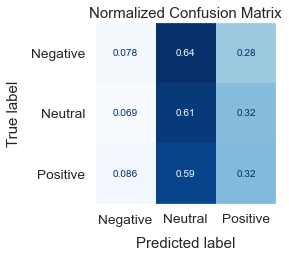

<IPython.core.display.Javascript object>

In [60]:
test_fit = partial(
    diag.test_fit,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
test_fit(main_pipe)

## Baseline Model

In [61]:
logit = LogisticRegression(
    class_weight="balanced",
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1e4,
    verbose=0,
    random_state=rando,
)
logit

LogisticRegression(class_weight='balanced', max_iter=10000.0,
                   multi_class='multinomial',
                   random_state=RandomState(MT19937) at 0x20C3F360240)

<IPython.core.display.Javascript object>

In [62]:
main_pipe.set_params(cls=logit)

Pipeline(steps=[('col',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('txt',
                                                  TfidfVectorizer(tokenizer=<function casual_tokenize at 0x0000020C39F05E50>),
                                                  'text'),
                                                 ('pos',
                                                  TfidfVectorizer(lowercase=False,
                                                                  tokenizer=<function space_tokenize at 0x0000020C3F197EE0>),
                                                  'pos_tags'),
                                                 ('bra',
                                                  TfidfVectorizer(tokenizer=<function space_tokenize at 0x0000020C3F197EE0>),
                                                  'brand_terms')])),
                ('cls',
                 LogisticRegression(class_weight='balanced', max_iter=10000.0,
    

<IPython.core.display.Javascript object>

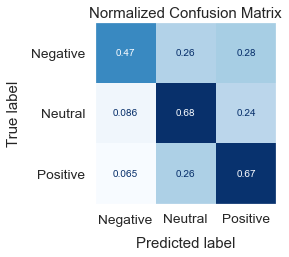

<IPython.core.display.Javascript object>

In [63]:
test_fit(main_pipe)

## Model Mark II

In [64]:
run_sweep = partial(
    sweep,
    X=X,
    y=y,
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=StratifiedKFold(),
    random_state=46,
)

<IPython.core.display.Javascript object>

### Select Tokenizer

In [65]:
grid = pd.Series(
    dict(
        tokenizer=[
            nltk.casual_tokenize,
            nltk.word_tokenize,
            nltk.wordpunct_tokenize,
            lang.space_tokenize,
            TreebankWordTokenizer().tokenize,
            NLTKWordTokenizer().tokenize,
            None,
        ]
    )
)

# run_sweep(
#     main_pipe,
#     grid.add_prefix("col__txt__"),
#     dst="sweeps/tokenizer",
#     kind="grid",
# )

<IPython.core.display.Javascript object>

In [66]:
results = load_results("sweeps/tokenizer.joblib")
results.tokenizer = results.tokenizer.map(str).map(lang.strip_punct)
results.style.bar("mean_score")

<IPython.core.display.Javascript object>

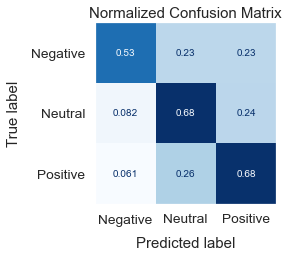

<IPython.core.display.Javascript object>

In [67]:
main_pipe.set_params(col__txt__tokenizer=nltk.wordpunct_tokenize)
test_fit(main_pipe)

### Optimize Punctuation Filter

In [68]:
# List of every punctuation mark, plus empty
keepers_to_try = list(string.punctuation) + [""]

# Try excluding each, individually
grid = dict(
    col__txt__preprocessor=[
        partial(lang.strip_punct, exclude=x) for x in keepers_to_try
    ]
)

del keepers_to_try

# run_sweep(main_pipe, grid, dst="sweeps/punctuation", kind="grid")

<IPython.core.display.Javascript object>

'!' and '?' are the two punctuation marks that really stand out. There are many others which are above the baseline None, but not significantly enough for me to exclude them (excluding too many makes the filter perform worse overall). It's interesting that '@' and '#' score below the baseline, indicating that these seemingly important Twitter symbols are actually noise where the model is concerned.

In [69]:
results = load_results("sweeps/punctuation")
results["preprocessor"] = (
    results["preprocessor"]
    .map(attrgetter("keywords"))
    .map(itemgetter("exclude"))
    .replace("", "None")
)
results.rename({"preprocessor": "retained_in_text"}, axis=1, inplace=True)
results.set_index("retained_in_text", inplace=True)
results.style.bar("mean_score")

<IPython.core.display.Javascript object>

### Select Filters

In [70]:
funcs = funcs.drop("strip_punct")
funcs["strip_punct"] = partial(lang.strip_punct, exclude="!?'<")
funcs

lowercase                    <function lowercase at 0x0000020C3F1938B0>
strip_short                <function strip_short at 0x0000020C3F193940>
strip_multiwhite      <function strip_multiwhite at 0x0000020C3F1939D0>
strip_numeric            <function strip_numeric at 0x0000020C3F193A60>
strip_non_alphanum    <function strip_non_alphanum at 0x0000020C3F19...
split_alphanum          <function split_alphanum at 0x0000020C3F193B80>
uni2ascii                    <function uni2ascii at 0x0000020C3F1971F0>
stem_text                    <function stem_text at 0x0000020C3F193F70>
strip_handles            <function strip_handles at 0x0000020C3F197040>
limit_repeats            <function limit_repeats at 0x0000020C3F193C10>
wordnet_lemmatize     <function wordnet_lemmatize at 0x0000020C3F19A...
mark_pos                      <function mark_pos at 0x0000020C3F19A5E0>
mark_negation            <function mark_negation at 0x0000020C3F19A9D0>
strip_punct           functools.partial(<function strip_punct at

<IPython.core.display.Javascript object>

In [71]:
# All preprocessing funcs plus None
grid = dict(col__txt__preprocessor=funcs.to_list() + [None])

# Turn off lowercasing to test its effectiveness
main_pipe.set_params(col__txt__lowercase=False)

# run_sweep(main_pipe, grid, dst="sweeps/filters", kind="grid")

Pipeline(steps=[('col',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('txt',
                                                  TfidfVectorizer(lowercase=False,
                                                                  tokenizer=<bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>),
                                                  'text'),
                                                 ('pos',
                                                  TfidfVectorizer(lowercase=False,
                                                                  tokenizer=<function space_tokenize at 0x0000020C3F197EE0>),
                                                  'pos_tags'),
                                                 ('bra',
                                                  TfidfVectorizer(tokenizer=<function space_tokenize at 0x

<IPython.core.display.Javascript object>

In [72]:
results = load_results("sweeps/filters")
results["preprocessor"] = results["preprocessor"].map(utils.get_func_name, "ignore")
results.style.bar("mean_score")

<IPython.core.display.Javascript object>

I include the top scorers and some others which are compatible and above the baseline.

In [73]:
text_pp = lang.make_preprocessor(
    [
        lang.lowercase,
        lang.stem_text,
        lang.mark_negation,
        lang.uni2ascii,
        lang.strip_multiwhite,
    ],
)


text_pp(df.text.head(10))

0     . @ wesley83 i have a 3g iphone. after 3 hr tw...
1     @ jessede know about @ fludapp? awesom ipad/ip...
2     @ swonderlin cannot wait<NEG for<NEG #<NEG ipa...
3     @ sxsw i hope thi year's festiv isn't as<NEG c...
4     @ sxtxstate great stuff on fri #sxsw: marissa ...
5     @ teachntech00 new ipad app for #speechtherapi...
7     #sxsw is just start, #ctia is around the corne...
8     beauti smart and simpl idea rt @ madebymani @ ...
9     count down the day to #sxsw plu strong canadia...
10    excit to meet the @ samsungmobileu at #sxsw so...
Name: text, dtype: object

<IPython.core.display.Javascript object>

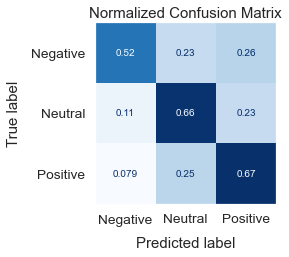

<IPython.core.display.Javascript object>

In [74]:
main_pipe.set_params(col__txt__preprocessor=text_pp)
test_fit(main_pipe)

### Select Stopwords

In [75]:
grid = dict(
    col__txt__stop_words=[
        gensim_stop,
        nltk_stop,
        my_stop,
        "english",
        None,
    ]
)

# run_sweep(
#     main_pipe,
#     grid,
#     dst="sweeps/stop_words",
# )

<IPython.core.display.Javascript object>

Looks like the best performers are my stopwords and the NLTK stopwords.

In [76]:
results = load_results("sweeps/stop_words")
results

stop_words  mean_score  rank_score
1  {s, his, each, about, out, and, i, while, what...    0.639148           1
2  {southbysouthwest, sxsw, quot, mention, sxswi,...    0.638196           2
4                                               None    0.636874           3
3                                            english    0.636557           4
0  {his, back, six, the, others, anyway, there, w...    0.635430           5

<IPython.core.display.Javascript object>

C:\Users\ndgig\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'n', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


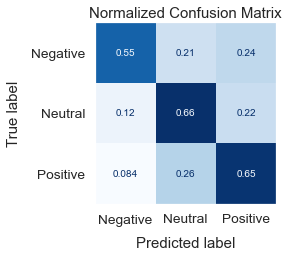

<IPython.core.display.Javascript object>

In [77]:
main_pipe.set_params(col__txt__stop_words=my_stop | nltk_stop)
test_fit(main_pipe)

### Select N-Gram Range

In [78]:
# grid = pd.Series(dict(ngram_range=utils.cartesian(1, np.arange(1, 4)).tolist()))
# run_sweep(main_pipe, grid.add_prefix("col__txt__"), dst="sweeps/text_ngrams")
# run_sweep(main_pipe, grid.add_prefix("col__pos__", dst="sweeps/pos_ngrams")

<IPython.core.display.Javascript object>

In [79]:
load_results("sweeps/text_ngrams").style.bar("mean_score")

<IPython.core.display.Javascript object>

In [80]:
grid = dict(col__pos__ngram_range=utils.cartesian(1, np.arange(1, 4)).tolist())
# run_sweep(main_pipe, grid, dst="sweeps/pos_ngrams")

<IPython.core.display.Javascript object>

In [81]:
load_results("sweeps/pos_ngrams").style.bar("mean_score")

<IPython.core.display.Javascript object>

## Model Mark III

### Toggle IDF

In [82]:
grid = pd.Series(dict(binary=[True, False], use_idf=[True, False]))

# run_sweep(main_pipe, grid.add_prefix("col__txt__"), dst="sweeps/txt_binary")
# run_sweep(main_pipe, grid.add_prefix("col__pos__"), dst="sweeps/pos_binary")
# run_sweep(main_pipe, grid.add_prefix("col__bra__"), dst="sweeps/bra_binary")

<IPython.core.display.Javascript object>

In [83]:
load_results("sweeps/txt_binary").style.bar("mean_score")

<IPython.core.display.Javascript object>

In [84]:
load_results("sweeps/pos_binary").style.bar("mean_score")

<IPython.core.display.Javascript object>

In [85]:
load_results("sweeps/bra_binary").style.bar("mean_score")

<IPython.core.display.Javascript object>

C:\Users\ndgig\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'n', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


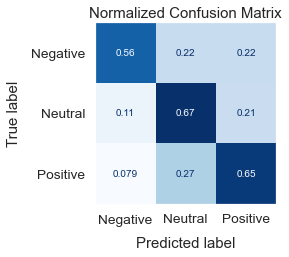

<IPython.core.display.Javascript object>

In [86]:
main_pipe.set_params(col__pos__use_idf=False)
test_fit(main_pipe)

### Add VADER Vectorizer

In [87]:
col_xform.transformers.append(("vad", VaderVectorizer(), "text"))
col_xform

ColumnTransformer(n_jobs=1,
                  transformers=[('txt',
                                 TfidfVectorizer(lowercase=False,
                                                 preprocessor=functools.partial(<function chain_funcs at 0x0000020C3F197CA0>, funcs=[<function lowercase at 0x0000020C3F1938B0>, <function stem_text at 0x0000020C3F193F70>, <function mark_negation at 0x0000020C3F19A9D0>, <function uni2ascii at 0x0000020C3F1971F0>, <function strip_multiwhite a...
                                                 tokenizer=<bound method RegexpTokenizer.tokenize of WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>),
                                 'text'),
                                ('pos',
                                 TfidfVectorizer(lowercase=False,
                                                 tokenizer=<function space_tokenize at 0x0000020C3F197EE0>,
                                          

<IPython.core.display.Javascript object>

Looks like a sizable ~0.01 increase in balanced accuracy by just adding 4 new features.

C:\Users\ndgig\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'n', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


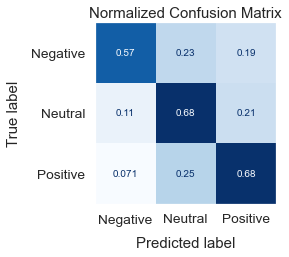

<IPython.core.display.Javascript object>

In [88]:
test_fit(main_pipe)

In [89]:
grid = pd.Series(
    dict(
        trinarize=[True, False],
        category_only=[True, False],
        compound_only=[True, False],
        norm=["l1", "l2", None],
    )
)

# run_sweep(main_pipe, grid.add_prefix("col__vad__"), dst="sweeps/vader_switches")

<IPython.core.display.Javascript object>

In [90]:
load_results("sweeps/vader_switches").dropna().style.bar("mean_score")

<IPython.core.display.Javascript object>

C:\Users\ndgig\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'n', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


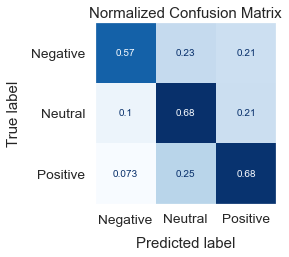

<IPython.core.display.Javascript object>

In [91]:
main_pipe.set_params(col__vad__norm="l1")
test_fit(main_pipe)

In [92]:
grid = dict(col__vad__preprocessor=funcs.to_list() + [None])
# run_sweep(main_pipe, grid, dst="sweeps/vader_pp")

<IPython.core.display.Javascript object>

I set leave the preprocessing off, because nothing stands out as markedly superior to the baseline. I also know that VADER accounts for things such as case.

In [93]:
results = load_results("sweeps/vader_pp")
results.preprocessor = results.preprocessor.map(utils.get_func_name, "ignore")
results.head(10).style.bar("mean_score")

<IPython.core.display.Javascript object>

C:\Users\ndgig\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'n', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


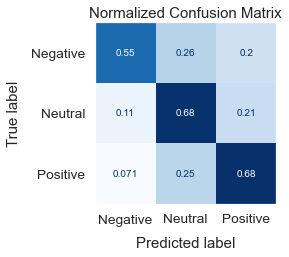

<IPython.core.display.Javascript object>

In [94]:
main_pipe.set_params(col__vad__preprocessor=funcs["strip_punct"])
test_fit(main_pipe)

## Model Mark IV
### Tune Document Frequency Limit

In [95]:
grid = pd.Series(dict(max_df=np.arange(0.0, 0.4, 0.05)))

# run_sweep(main_pipe, grid.add_prefix("col__txt__"), dst="sweeps/max_df")

<IPython.core.display.Javascript object>

In [96]:
load_results("sweeps/max_df").head(10).style.bar("mean_score")

<IPython.core.display.Javascript object>

C:\Users\ndgig\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'n', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


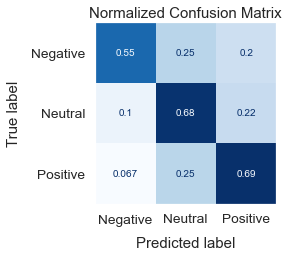

<IPython.core.display.Javascript object>

In [97]:
main_pipe.set_params(col__txt__max_df=0.15)
test_fit(main_pipe)

### Cap PoS Features

In [98]:
grid = dict(col__pos__max_features=np.arange(10, 50, 5))
# run_sweep(main_pipe, grid, dst="sweeps/pos_max_feat")

<IPython.core.display.Javascript object>

In [99]:
load_results("sweeps/pos_max_feat").head(10).style.bar("mean_score")

<IPython.core.display.Javascript object>

C:\Users\ndgig\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'n', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


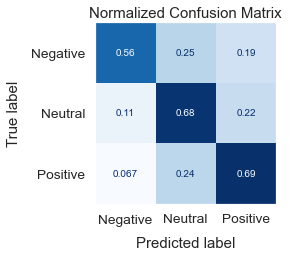

<IPython.core.display.Javascript object>

In [100]:
main_pipe.set_params(col__pos__max_features=25)
test_fit(main_pipe)

### Tune L2 Regularization Strength

In [101]:
grid = dict(cls__C=np.geomspace(1e-4, 1e4, 9))

# run_sweep(main_pipe, grid, dst="sweeps/penalty")

<IPython.core.display.Javascript object>

Looks like the default value of 1.0 is actually the best.

In [102]:
load_results("sweeps/penalty").style.bar("mean_score")

<IPython.core.display.Javascript object>

Save final confusion matrix for the presentation.

C:\Users\ndgig\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'n', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


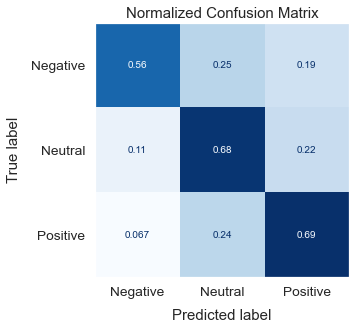

<IPython.core.display.Javascript object>

In [103]:
fig = diag.classification_plots(
    main_pipe.fit(X_train, y_train), X_test, y_test, pos_label="Positive"
)
fig.savefig(normpath("images/final_confusion_matrix.svg"))

## Refit with Final Parameters

In [104]:
main_pipe.fit(X, y)

C:\Users\ndgig\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'n', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Pipeline(steps=[('col',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('txt',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_df=0.15,
                                                                  preprocessor=functools.partial(<function chain_funcs at 0x0000020C3F197CA0>, funcs=[<function lowercase at 0x0000020C3F1938B0>, <function stem_text at 0x0000020C3F193F70>, <function mark_negation at 0x0000020C3F19A9D0>, <function uni2ascii at 0x0000020C3...
                                                  TfidfVectorizer(tokenizer=<function space_tokenize at 0x0000020C3F197EE0>),
                                                  'brand_terms'),
                                                 ('vad',
                                                  VaderVectorizer(norm='l1',
                                                              

<IPython.core.display.Javascript object>

# Interpretation

In [105]:
feat_names = col_xform.get_feature_names()
classes = main_pipe["cls"].classes_
coef = pd.DataFrame(main_pipe["cls"].coef_, columns=feat_names, index=classes).T
coef.sort_values("Negative", ascending=False)

Negative   Neutral  Positive
txt__headach  3.283711 -1.728618 -1.555093
txt__suck     2.563031 -1.507252 -1.055779
txt__crash    2.363819 -0.945353 -1.418466
txt__fade     2.289282 -1.210290 -1.078992
txt__long     2.272337 -1.125618 -1.146719
...                ...       ...       ...
txt__cool    -1.529093 -1.132311  2.661404
txt__make    -1.675442  0.787832  0.887611
txt__free    -1.731615  1.062679  0.668936
bra__        -1.919691  2.359210 -0.439519
txt__win     -2.065828  1.596376  0.469451

[8467 rows x 3 columns]

<IPython.core.display.Javascript object>

In [106]:
coef.abs().max(axis=1).sort_values(ascending=False).head(15)

txt__headach    3.283711
txt__cool       2.661404
txt__suck       2.563031
txt__?          2.385904
txt__crash      2.363819
bra__           2.359210
txt__fade       2.289282
txt__long       2.272337
txt__fail       2.184192
txt__ridic      2.112989
txt__delet      2.109710
txt__win        2.065828
txt__fuck       2.049071
txt__ipad2s     2.016096
txt__button     1.954261
dtype: float64

<IPython.core.display.Javascript object>

In [107]:
coef.agg(["min", "max"])

Negative   Neutral  Positive
min -2.065828 -1.889423 -2.385904
max  3.283711  2.359210  2.661404

<IPython.core.display.Javascript object>

In [108]:
def get_coefs(
    prefix,
    index_name,
    coef=coef,
    titlecase=True,
    icase=False,
):
    data = coef.filter(like=f"{prefix}__", axis=0)

    # Remove prefix
    data.index = data.index.str.replace("\w+__", "", regex=True)

    # Make snake_case titlecase
    data.index.name = index_name
    if titlecase:
        data = utils.title_mode(data)
        if icase:
            data.index = data.index.str.replace("Ip", "iP")
    return data.sort_values("Positive")

<IPython.core.display.Javascript object>

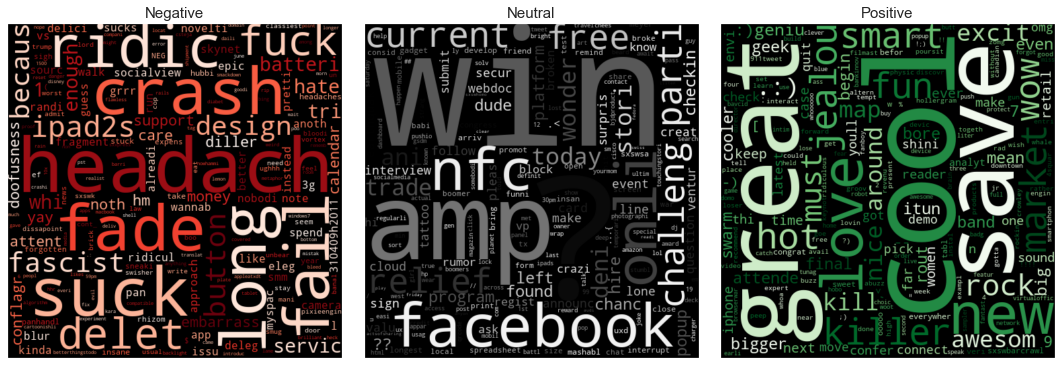

<IPython.core.display.Javascript object>

In [109]:
text_coef = get_coefs("txt", "Text", titlecase=False)

fig = plotting.wordcloud(
    text_coef,
    cmap=dict(Negative="Reds", Neutral="Greys", Positive="Greens"),
    size=(5, 5),
    random_state=rando,
)
fig.savefig(normpath("images/txt_coef_wordclouds.svg"), bbox_inches="tight")

In [110]:
brand_coef = get_coefs("bra", "Brand", icase=True)
brand_coef.index = ["None"] + brand_coef.index.to_list()[1:]
if "iPhoneapp" in brand_coef.index:
    brand_coef.drop("iPhoneapp", inplace=True)
brand_coef

Negative   Neutral  Positive
None        -1.919691  2.359210 -0.439519
iPhone       0.367175 -0.307703 -0.059472
Google      -0.055558 -0.098785  0.154343
Android     -0.333076  0.054263  0.278813
Android App  0.042697 -0.392867  0.350170
iPhone App   0.063877 -0.432864  0.368986
Apple       -0.089227 -0.340417  0.429643
iPad        -0.057912 -0.403961  0.461873
iPad App    -0.381878 -0.167770  0.549648

<IPython.core.display.Javascript object>

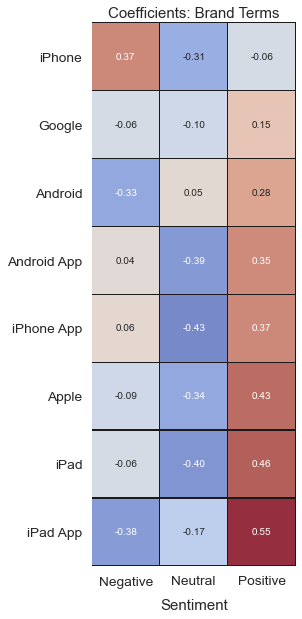

<IPython.core.display.Javascript object>

In [123]:
fig, ax = plt.subplots(figsize=(4, 10))
hm_style = dict(plotting.HEATMAP_STYLE)
del hm_style["square"]

if "None" in brand_coef.index:
    brand_coef.drop("None", inplace=True)

sns.heatmap(brand_coef.sort_values("Positive"), ax=ax, square=True, **hm_style)

ax.set(xlabel="Sentiment", title="Coefficients: Brand Terms")
fig.savefig(normpath("images/brand_term_coef.svg"), bbox_inches="tight")

In [112]:
pos_coef = get_coefs("pos", "Part of Speech", titlecase=False)
pos_coef.head()

Negative   Neutral  Positive
Part of Speech                              
VB              0.477542  0.144217 -0.621759
PRP$            0.551940 -0.123881 -0.428059
NNS             0.772287 -0.410297 -0.361990
NNP             0.173685  0.064806 -0.238491
RB              1.086121 -0.899179 -0.186942

<IPython.core.display.Javascript object>

In [113]:
tb_pos = pd.read_csv(
    normpath("data/penn_treebank_pos.csv"),
    usecols=["Tag", "Description"],
    index_col="Tag",
    encoding="utf-8",
    squeeze=True,
)
tb_pos.head()

Tag
CC    Coordinating conjunction
CD             Cardinal number
DT                  Determiner
EX           Existential there
FW                Foreign word
Name: Description, dtype: object

<IPython.core.display.Javascript object>

In [114]:
pos_coef.index = pos_coef.index.map(tb_pos)
pos_coef.sort_values("Negative", inplace=True)
pos_coef = pos_coef.loc[pos_coef.index.notnull()]
pos_coef.head()

Negative   Neutral  Positive
Part of Speech                                                        
Particle                                 -0.869283  0.626998  0.242285
Cardinal number                          -0.800229  0.767373  0.032856
Coordinating conjunction                 -0.539225  0.424832  0.114393
Preposition or subordinating conjunction -0.256151  0.033723  0.222428
Verb, past participle                    -0.066651 -0.254394  0.321044

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Part of Speech'>

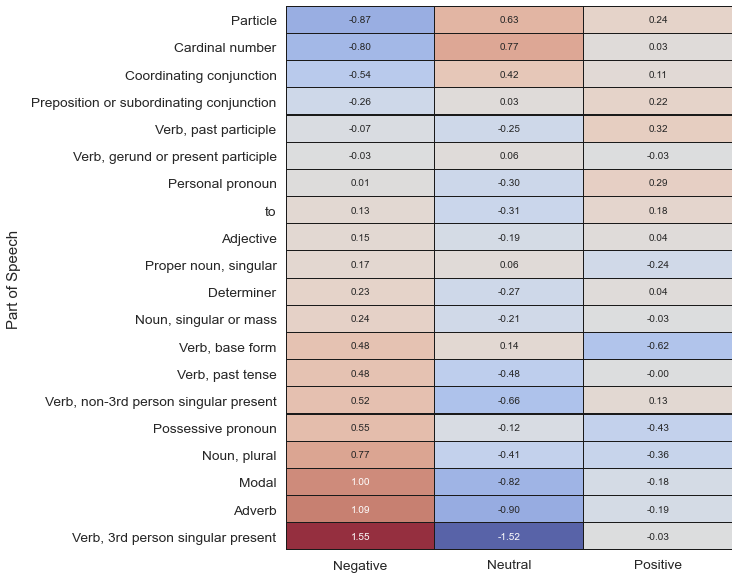

<IPython.core.display.Javascript object>

In [115]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(pos_coef.dropna(), ax=ax, **hm_style)

[Text(0.5, 44.77499999999999, 'VADER Valence'),
 Text(13.109374999999996, 0.5, 'Sentiment'),
 Text(0.5, 1.0, 'Regression Coefficients: VADER')]

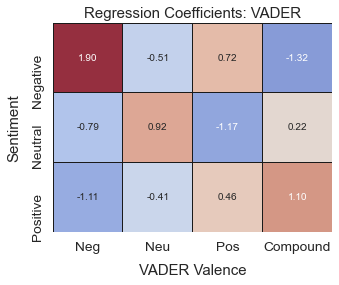

<IPython.core.display.Javascript object>

In [116]:
fig, ax = plt.subplots(figsize=(5, 5))
vad_coef = coef.filter(like="vad__", axis=0)
vad_coef.index = vad_coef.index.str.replace("vad__", "")
vad_coef = utils.title_mode(vad_coef).T
sns.heatmap(vad_coef, ax=ax, **hm_style, square=True)
ax.set(
    xlabel="VADER Valence",
    ylabel="Sentiment",
    title="Regression Coefficients: VADER",
)

# Recommendations

#### 1. Try to shake your authoritarian image by allowing end-users more freedom in some respect, and widely publicizing this fact.

#### 2. AT&T's spotty service is crippling your product. You should work with other wireless providers.

#### 3. Expand the App Store offerings for iPad.
There is a lot of enthusiasm about iPad apps, and less about iPhone apps and iPhone in general. Focus more energy on iPad apps.